#### Author : Mehar Chaturvedi
#### Date of creation : 04/20/2022
#### Last Modified : 
#### Aim : 
#### Input : 

In [1]:
# loading libararies
from keras.datasets import cifar10
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import cv2
import glob
import random
import tensorflow as tf
import copy
import warnings
warnings.filterwarnings("ignore")
import skdim

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import RobustScaler
from scipy import stats

from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import mean_squared_error,plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.manifold import SpectralEmbedding

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
# setting seed
global seed
seed = 2022

os.environ['PYTHONHASHSEED']=str(seed)

random.seed(seed)

np.random.seed(seed)

tf.random.set_seed(seed)

In [3]:
# defining parameters
# defining path where the data is stored.
path = './input'
num_classes = 3
label_names = {0:'standing', 1:'walking', 2:'jumping'}
sensor_location = ['chest','thigh']
activity = ['standing','walking','jumping']
features = ['attr_x','attr_y','attr_z']
window_size = 128
window_overlap = 0.5

val_size = 0.2
test_size = 0.2

k_values = np.arange(1,21)
distance = 'euclidean' # distance metric for knns

## Step 1 : Getting the raw data from 6 csv files.
Data is split into windows of one second of observations (128) with a 50% overlap between windows.

In [4]:
# storing data as key-value pair, where key indicates the activity and sensor location.
# Adding date as the index for each csv file. This will be required to perform oversampling to balance the dataset.
data = {}
print('The following are the no. of samples and features for each activity and sensor : ')
for i in activity:
    for j in sensor_location:
        data['acc_'+i+'_'+j] = pd.read_csv(os.path.join(path,"acc_"+i+"_"+j+".csv"))
        data['acc_'+i+'_'+j].drop(['id','attr_time'], inplace=True, axis=1) # removing time stamp and id feature
        #data['acc_'+i+'_'+j]['date'] = pd.date_range(start='1/1/1979', periods=data['acc_'+i+'_'+j].shape[0], freq='D')
        #data['acc_'+i+'_'+j].drop(['id','attr_time'], inplace=True, axis=1) # removing time stamp and id feature
        #data['acc_'+i+'_'+j].set_index('date', inplace=True)
        print('acc_'+i+'_'+j+' ' + str(data['acc_'+i+'_'+j].shape))
        
# showing first few rows for 1 csv
data['acc_'+i+'_'+j].head()

The following are the no. of samples and features for each activity and sensor : 
acc_standing_chest (32119, 3)
acc_standing_thigh (32119, 3)
acc_walking_chest (31950, 3)
acc_walking_thigh (31949, 3)
acc_jumping_chest (4331, 3)
acc_jumping_thigh (4326, 3)


,attr_x,attr_y,attr_z
0,-0.131681,9.577405,0.044891
1,-0.147243,9.589376,0.035314
2,-0.146046,9.564238,0.046687
3,-0.161010,9.570223,0.026935
4,-0.174178,9.579201,0.028730


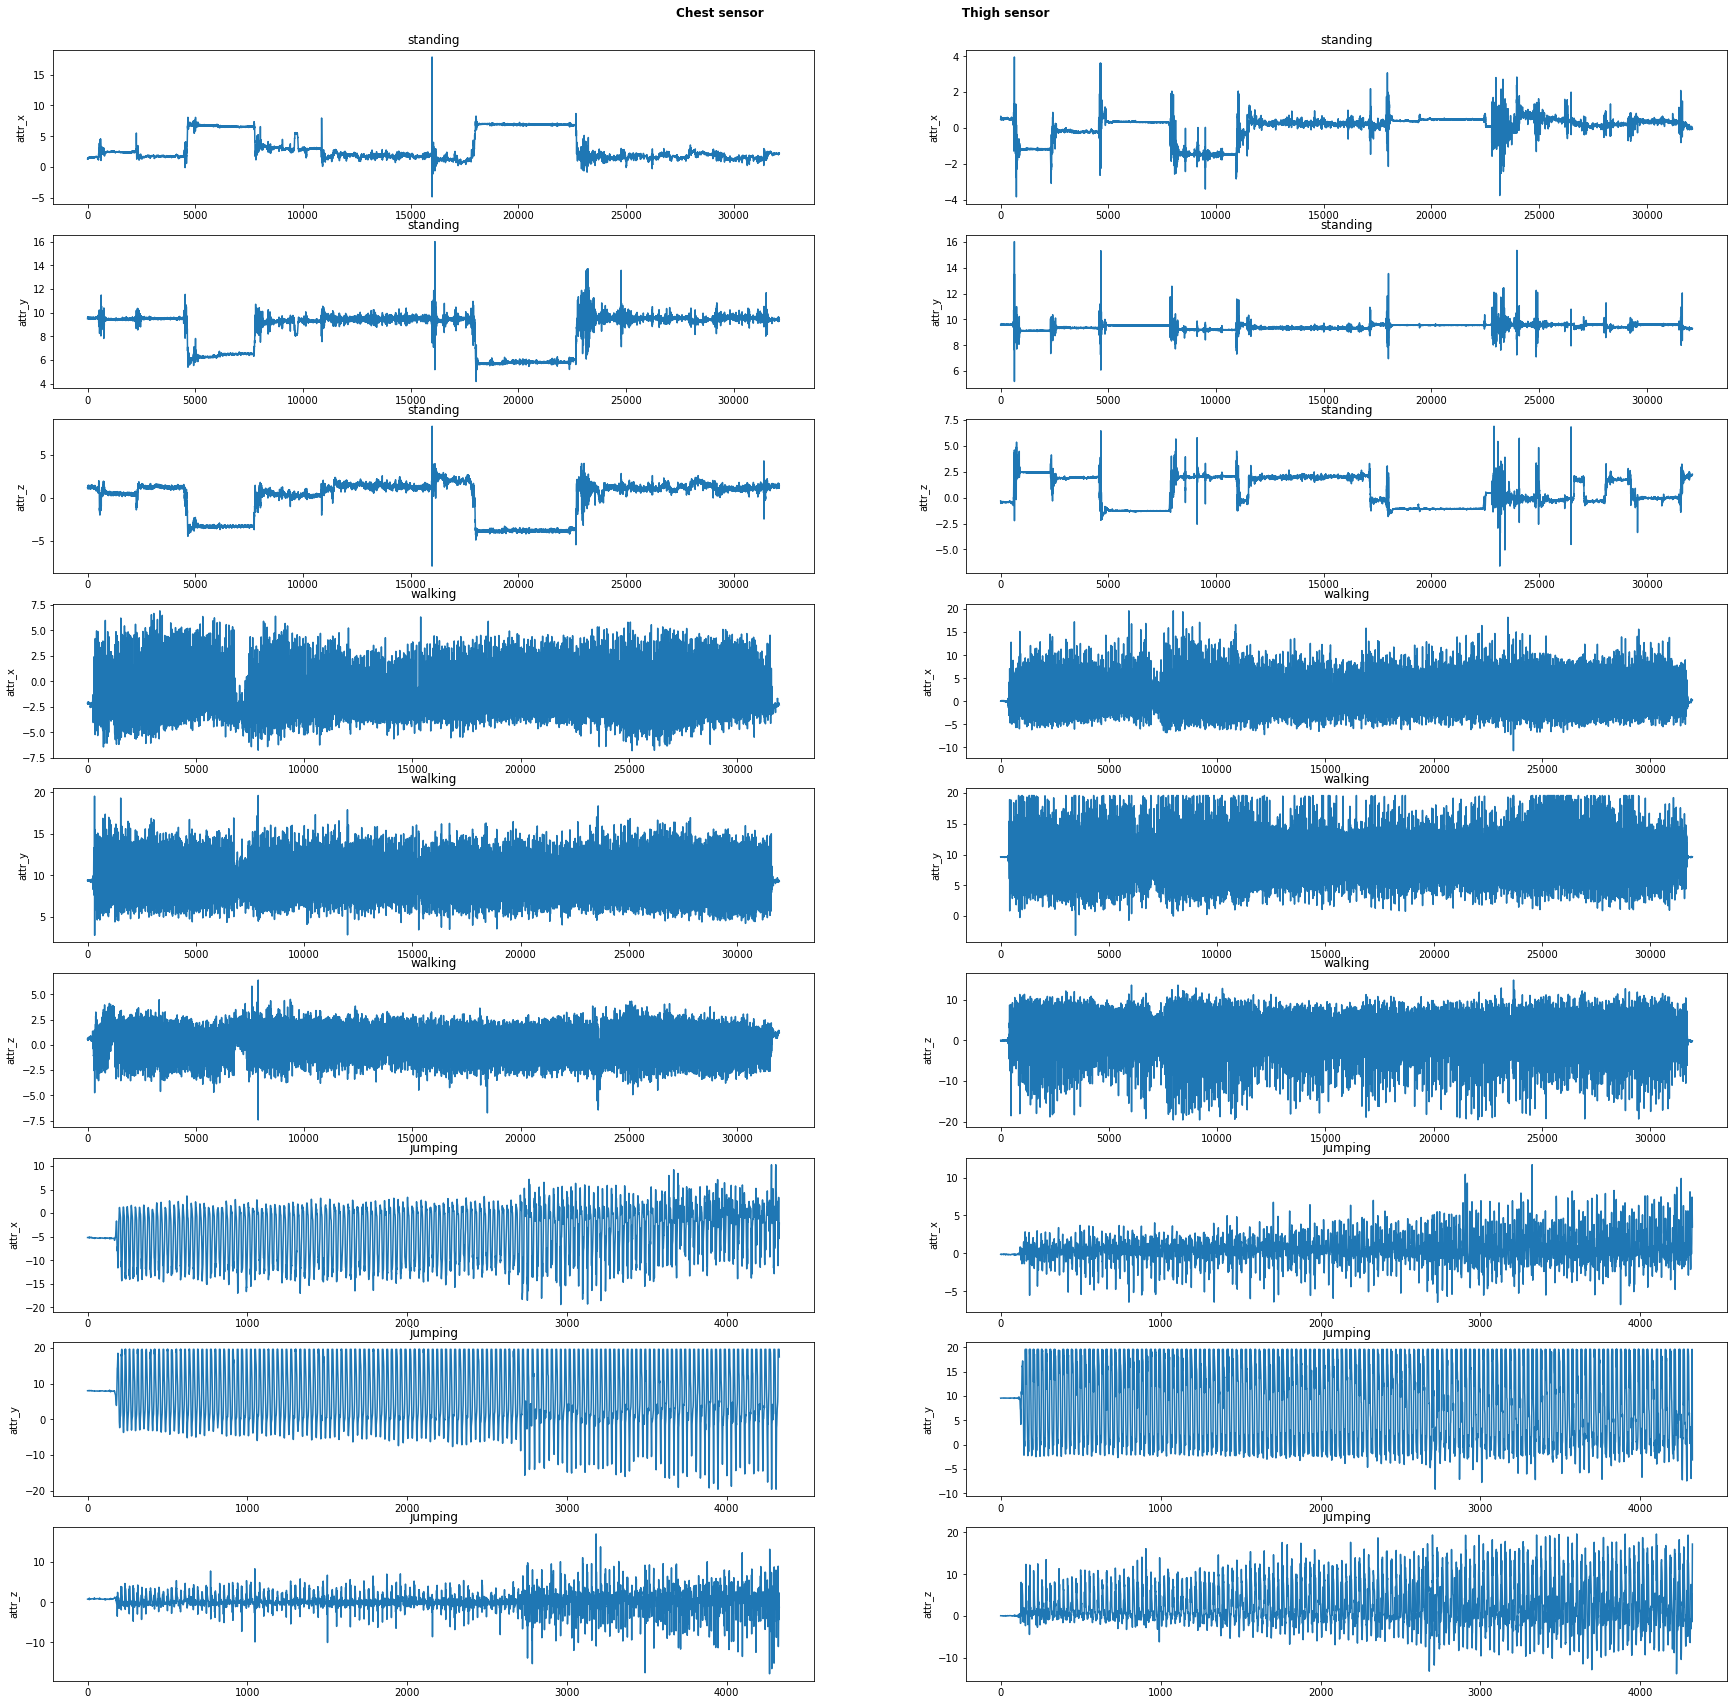

In [5]:
# How different do the activities and sensor data look?

# define figure
cols = len(sensor_location)
rows = len(activity)*len(features)
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Chest sensor                                                Thigh sensor', fontweight = "bold", y = 0.9)
i = 1 

# visualize x, y and z coordinates data for each sensor location and activity.
while i <= cols*rows:   
    for a in activity:
        for f in features:
            for l in sensor_location:
                fig.add_subplot(rows, cols, i)
                plt.plot(data['acc_'+a+'_'+l][f])
                plt.ylabel(f)
                i+=1
                plt.title(a)
        
plt.show()

We make the following assumptions about the data:
1. There is no temporal relation across activities and sensor data.
2. The given data represents 1 subject.

From the plot shown above, we conclude the following:
1. The data should be scaled per activity and per sensor.
2. Jumping is underrepresented. Hence, the dataset has to be balanced.
3. Based on the first 1000 samples, it might be difficult to differentiate between standing and walking. Hence, discarding these samples might be useful.
4. As expected, there is a higher acceleration for activities such as jogging and walking compared to standing.

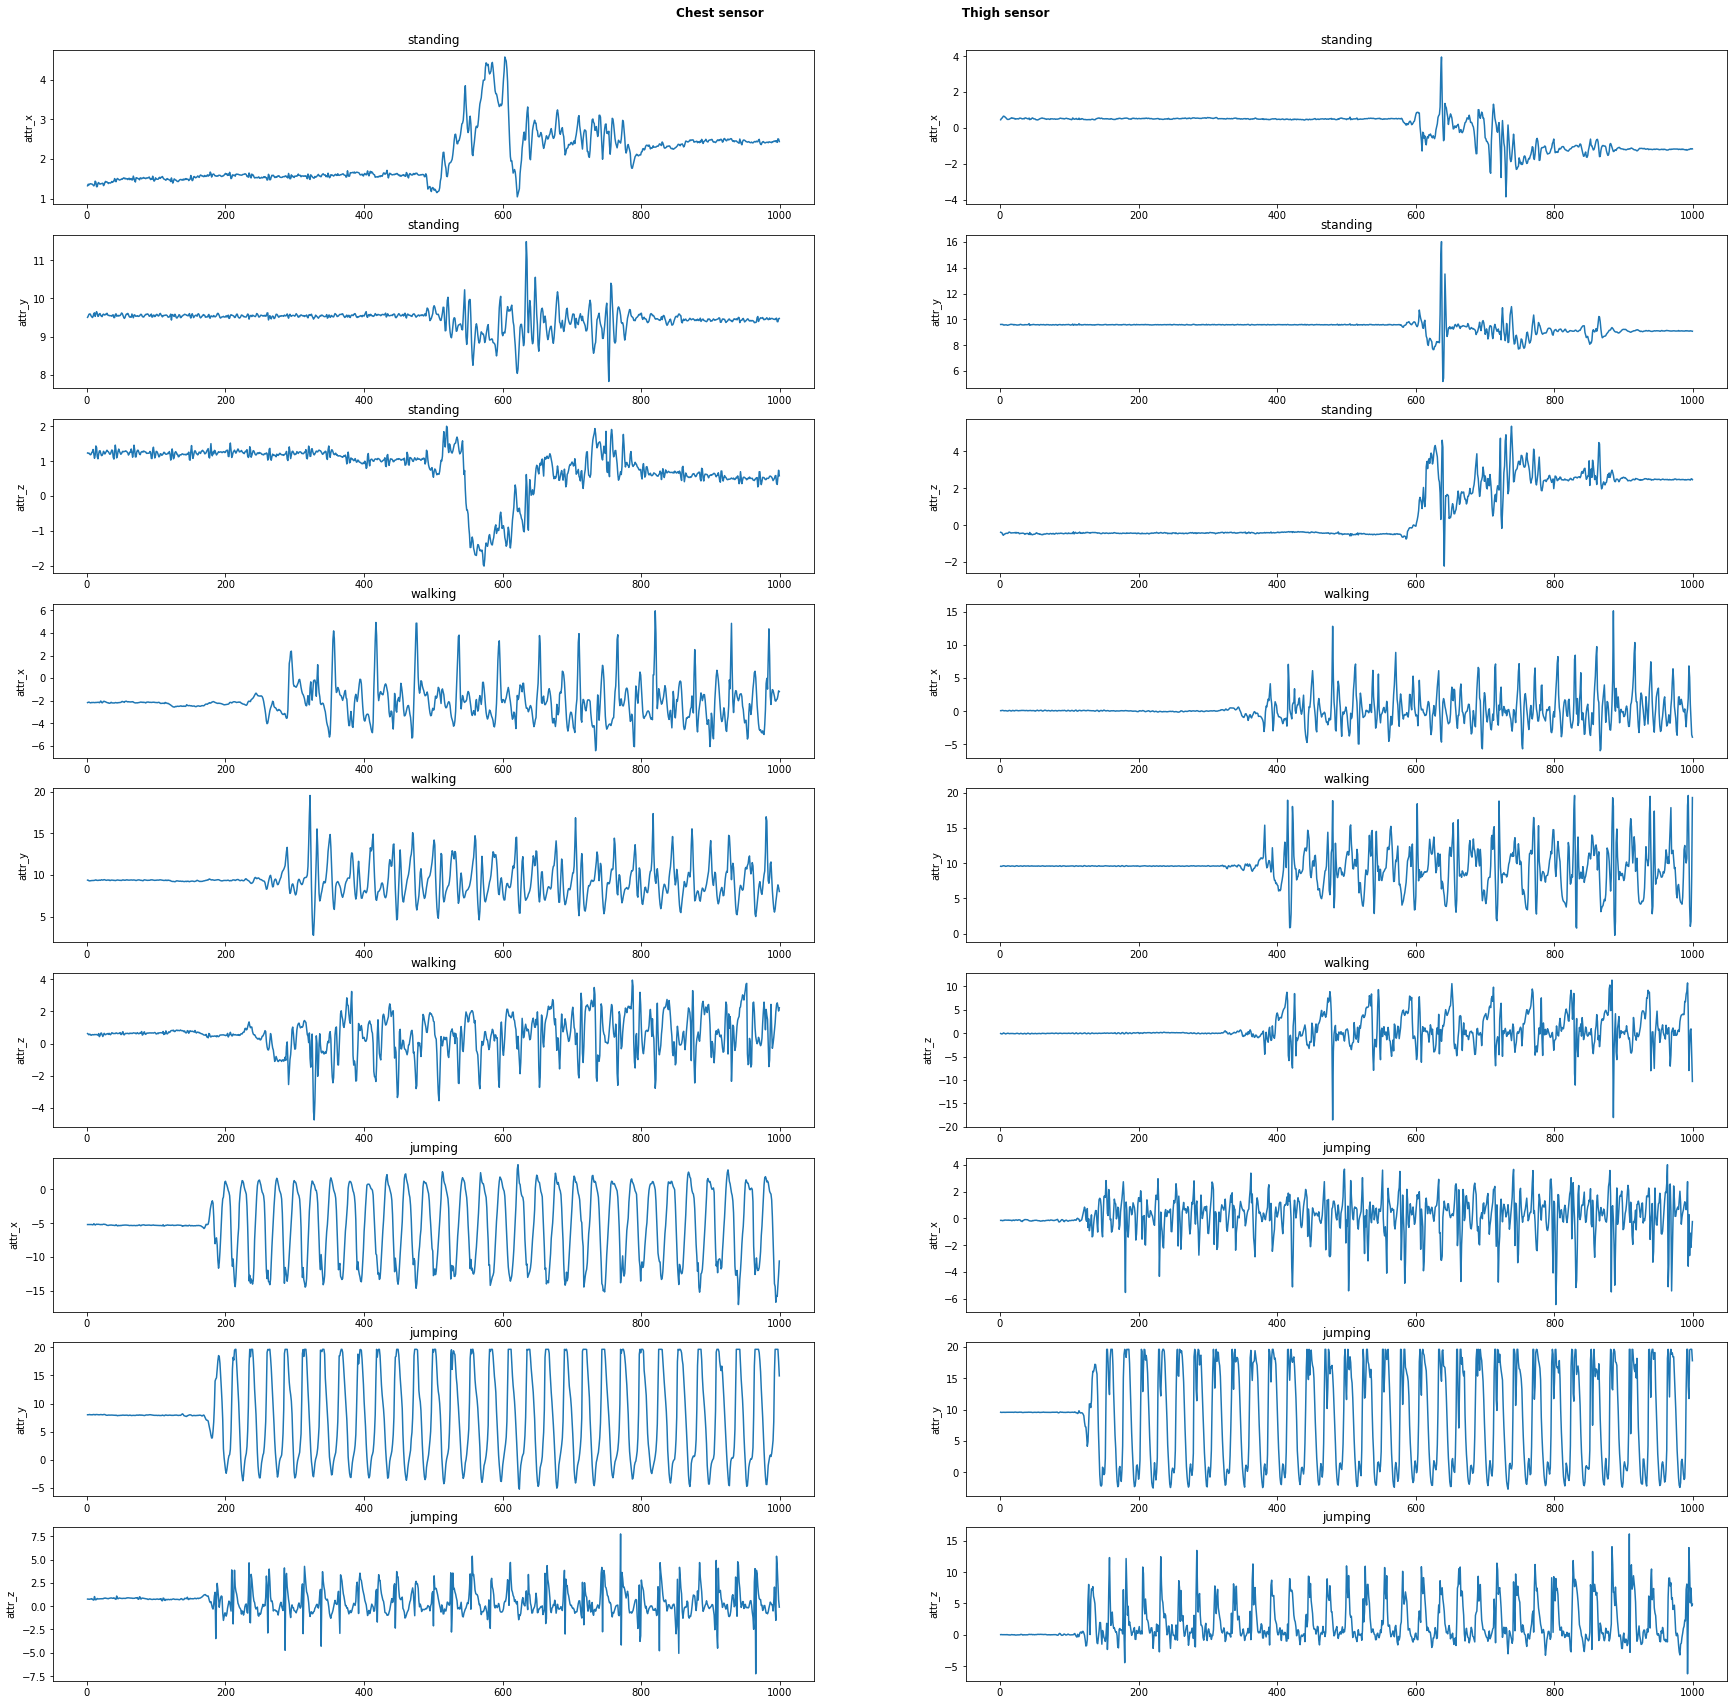

In [6]:
# Are first 1000 samples useful in differentiating between activities?

# define figure
cols = len(sensor_location)
rows = len(activity)*len(features)
fig = plt.figure(figsize=(30, 30))
fig.suptitle('Chest sensor                                                Thigh sensor', fontweight = "bold", y = 0.9)
i = 1 

# visualize x, y and z coordinates data for each sensor location and activity.
while i <= cols*rows:   
    for a in activity:
        for f in features:
            for l in sensor_location:
                fig.add_subplot(rows, cols, i)
                plt.plot(data['acc_'+a+'_'+l][f][1:1000])
                plt.ylabel(f)
                i+=1
                plt.title(a)
        
plt.show()

From above graphs, it is to be concluded that discrading the first 1000 samples is unnecessary. Instead, only first 500 samples should be discarded. We further make sure that the activities can be discriminated based on the data by plotting the histogram.

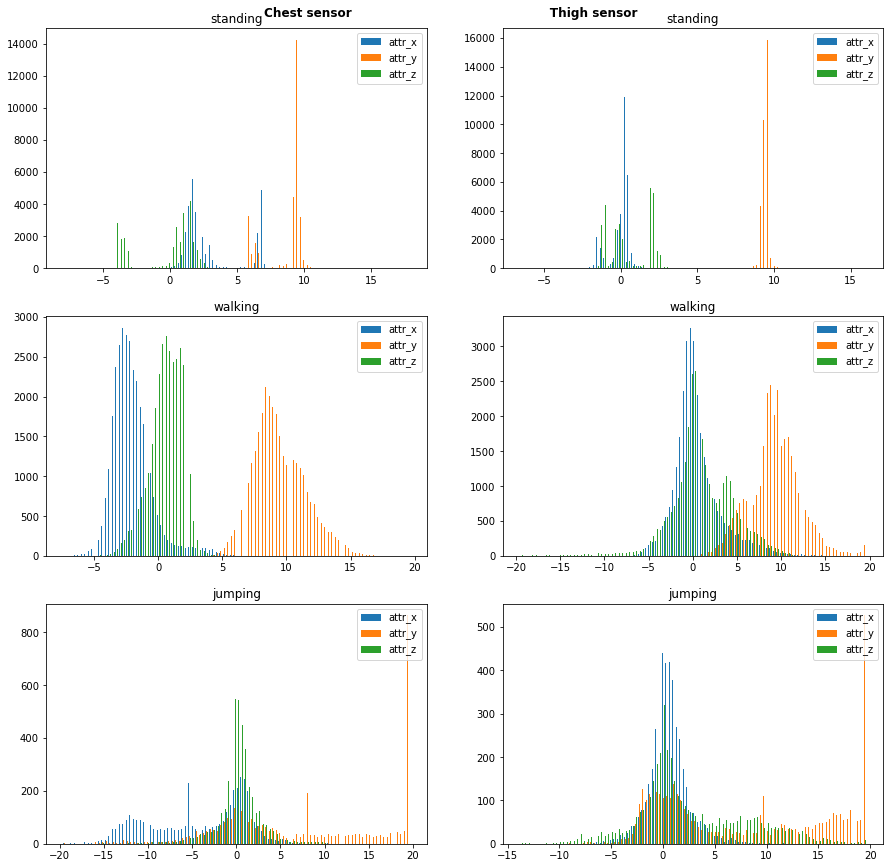

In [7]:
# Creating a histogram plot per activity and per sensor, with the three axis of a given data type on each plot.

# define figure
cols = len(sensor_location)
rows = len(activity)
fig = plt.figure(figsize=(15,15))
fig.suptitle('Chest sensor                                                Thigh sensor', fontweight = "bold", y = 0.9)
i = 1 

# visualize x, y and z coordinates data for each sensor location and activity.
while i <= cols*rows:   
    for a in activity:
        for l in sensor_location:
            fig.add_subplot(rows, cols, i)
            temp = data['acc_'+a+'_'+l]
            plt.hist([temp[features[0]], temp[features[1]],temp[features[2]]], label=features, bins = 100)
            plt.legend(loc='upper right')
            i+=1
            plt.title(a) 
            

plt.show()

Distribution for activities looks gaussian with the following highlights:
1. Standing has bimodal distribution
2. Walking has unimodal normal distribution
3. Jumping shows a fat-tailed distribution for y coordinate an almost unimodal for other axis.

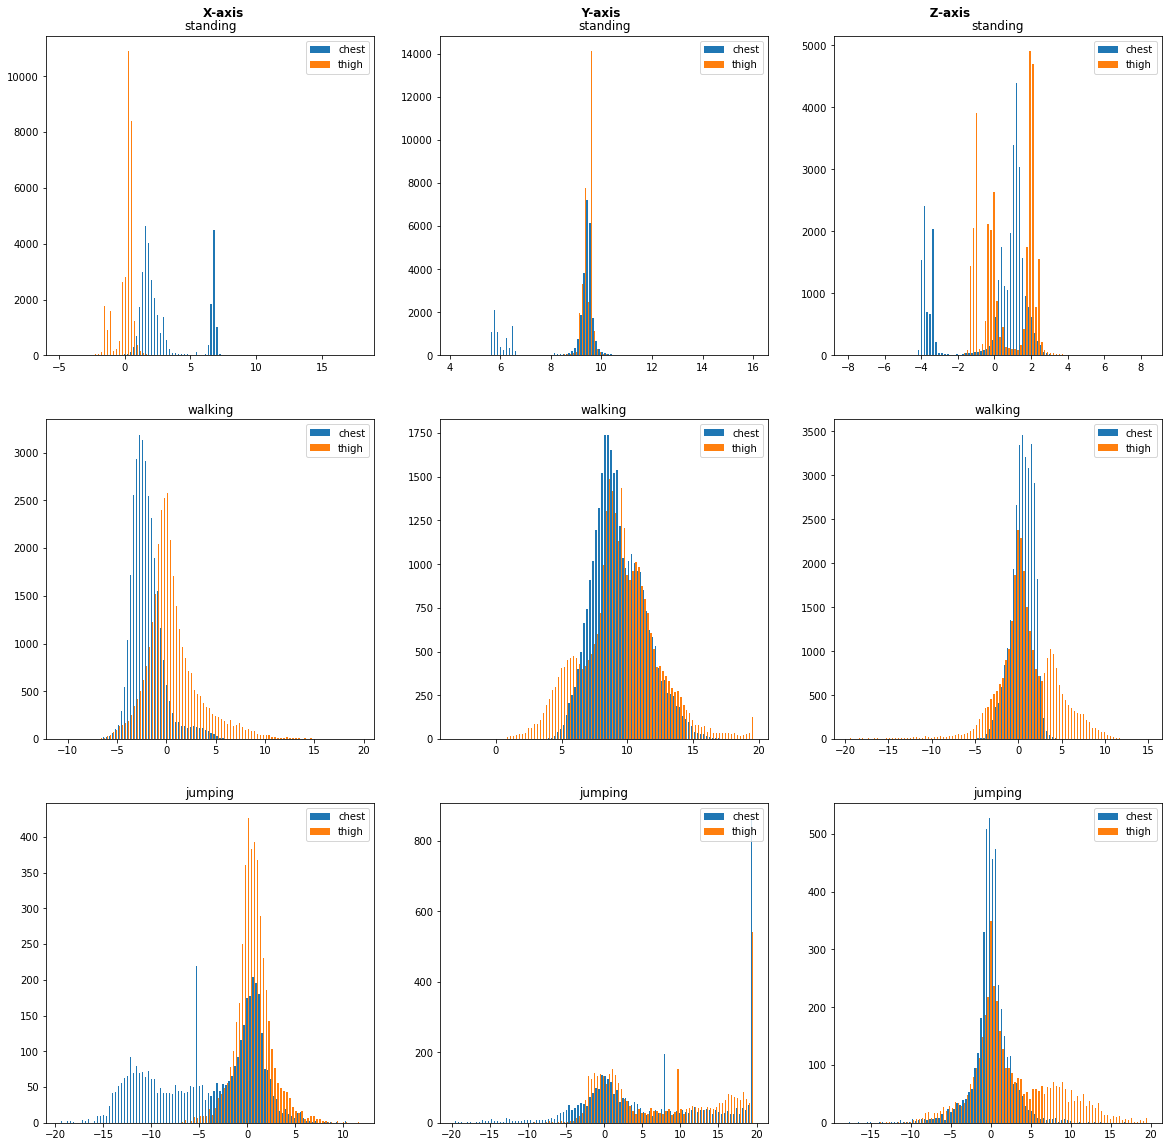

In [8]:
# plotting histogram to understand whether data will help in discriminating the sensor location
# define figure
cols = len(features)
rows = len(activity)
fig = plt.figure(figsize=(20,20))
fig.suptitle('X-axis                                                                                  Y-axis                                                                           Z-axis', fontweight = "bold", y = 0.9)
i = 1 

# visualize x, y and z coordinates data for each sensor location and activity.
while i <= cols*rows:   
    for a in activity:
        temp_chest = data['acc_'+a+'_chest']
        temp_thigh = data['acc_'+a+'_thigh']
        for f in features:
            fig.add_subplot(rows, cols, i)        
            plt.hist([temp_chest[f], temp_thigh[f]], label=['chest','thigh'], bins = 100)
            plt.legend(loc='upper right')
            i+=1
            plt.title(a) 
            
plt.show()

Using information from all 3 axis, it appears that using both sensors will be useful

## Step 2 : Preprocessing the data
1. Removing first 500 samples
2. Check for missing values.
3. Balancing data by oversampling.
4. Merging data to create one dataframe.
5. Scaling the data
6. Creating train and test datasets for predictors and output, separately.
7. Change data format from (N, 3) to (N', window size , 3). This is done in order to presever temporal information and overrepresent jumping data.xs

In [9]:
# removing first 500 samples
for a in activity:
    for s in sensor_location:
        data['acc_'+a+'_'+s].drop(data['acc_'+a+'_'+s].index[0:500],inplace=True)
        print('acc_'+a+'_'+s+' ' + str(data['acc_'+a+'_'+s].shape))

acc_standing_chest (31619, 3)
acc_standing_thigh (31619, 3)
acc_walking_chest (31450, 3)
acc_walking_thigh (31449, 3)
acc_jumping_chest (3831, 3)
acc_jumping_thigh (3826, 3)


In [10]:
# Checking for missing values.
for a in activity:
    for s in sensor_location:
        print('acc_'+a+'_'+s+' ' + str(data['acc_'+a+'_'+s].isna().sum().sum()))
        
# No missing value

acc_standing_chest 0
acc_standing_thigh 0
acc_walking_chest 0
acc_walking_thigh 0
acc_jumping_chest 0
acc_jumping_thigh 0


In [11]:
# Balancing data for jumping
data_balanced = {}
for a in activity:
    for s in sensor_location:
        if a!='jumping':
            data_balanced['acc_'+a+'_'+s] = copy.deepcopy(data['acc_'+a+'_'+s])
        else:
            temp = copy.deepcopy(data['acc_'+a+'_'+s])
            data_balanced['acc_'+a+'_'+s] = pd.DataFrame(np.repeat(data['acc_'+a+'_'+s].values, 8, axis=0), columns=data['acc_'+a+'_'+s].columns)
        print('acc_'+a+'_'+s+' ' + str(data_balanced['acc_'+a+'_'+s].shape))

acc_standing_chest (31619, 3)
acc_standing_thigh (31619, 3)
acc_walking_chest (31450, 3)
acc_walking_thigh (31449, 3)
acc_jumping_chest (30648, 3)
acc_jumping_thigh (30608, 3)


In [12]:
# undersampling

"""
# find minimum no. samples across 6 csv files and use that for sample extraction.
min_rows = 1e+9
for a in activity:
    for s in sensor_location:
        if min_rows> data['acc_'+a+'_'+s].shape[0]:
            min_rows = data['acc_'+a+'_'+s].shape[0]
            
print('No. of common rows across files : {}'.format(min_rows))

# Balancing data
data_balanced = {}
for a in activity:
    for s in sensor_location:
        temp = copy.deepcopy(data['acc_'+a+'_'+s])
        data_balanced['acc_'+a+'_'+s] = temp.iloc[0:min_rows,:]
        print('acc_'+a+'_'+s+' ' + str(data_balanced['acc_'+a+'_'+s].shape))
"""


"\n# find minimum no. samples across 6 csv files and use that for sample extraction.\nmin_rows = 1e+9\nfor a in activity:\n    for s in sensor_location:\n        if min_rows> data['acc_'+a+'_'+s].shape[0]:\n            min_rows = data['acc_'+a+'_'+s].shape[0]\n            \nprint('No. of common rows across files : {}'.format(min_rows))\n\n# Balancing data\ndata_balanced = {}\nfor a in activity:\n    for s in sensor_location:\n        temp = copy.deepcopy(data['acc_'+a+'_'+s])\n        data_balanced['acc_'+a+'_'+s] = temp.iloc[0:min_rows,:]\n        print('acc_'+a+'_'+s+' ' + str(data_balanced['acc_'+a+'_'+s].shape))\n"

In [13]:
# Merge chest and thigh sensor data for each activity followed by creating a new column that labels the activity.
data_merged1 = {}
for a in activity:
    temp1 = copy.deepcopy(data_balanced['acc_'+a+'_'+sensor_location[0]])
    temp2 = copy.deepcopy(data_balanced['acc_'+a+'_'+sensor_location[1]])
    temp1.columns = [sensor_location[0]+'_'+f for f in temp1.columns.to_list()]
    temp2.columns = [sensor_location[1]+'_'+f for f in temp2.columns.to_list()]
    # merge sensors by taking min(rows in chest,rows in thigh) from both the sensor data for each activity
    min_row = min(temp1.shape[0],temp2.shape[0])
    data_merged1[a] = pd.concat([temp1.iloc[0:min_row,:],temp2.iloc[0:min_row,:]],axis=1)
    data_merged1[a]['activity'] = activity.index(a)
    print('Activity : '+a + str(data_merged1[a].shape))

Activity : standing(31619, 7)
Activity : walking(31449, 7)
Activity : jumping(30608, 7)


In [14]:
# dividing data_merged1 into train and test for each activity.
train_dict = {}
test_dict = {}
for a in activity:
    num_train = int(data_merged1[a].shape[0]*(1-test_size))
    train_dict[a] = data_merged1[a].iloc[0:(num_train+1),:]
    test_dict[a] = data_merged1[a].iloc[(num_train+1):,:]
    print('Activity : '+a + '\n Training : '+str(train_dict[a].shape) + ' ,Testing : '+str(test_dict[a].shape))

Activity : standing
 Training : (25296, 7) ,Testing : (6323, 7)
Activity : walking
 Training : (25160, 7) ,Testing : (6289, 7)
Activity : jumping
 Training : (24487, 7) ,Testing : (6121, 7)


In [15]:
# Merging training and testing datasets across activities.
train = pd.concat([train_dict[activity[0]],train_dict[activity[1]],train_dict[activity[2]]],axis=0)
test = pd.concat([test_dict[activity[0]],test_dict[activity[1]],test_dict[activity[2]]],axis=0)
print (train.shape, test.shape)

(74943, 7) (18733, 7)


In [16]:
# Seperating Predictors and Outcome values from train and test sets
X_train2 = pd.DataFrame(train.drop(['activity'],axis=1))
y_train2 = pd.DataFrame(train['activity'])
X_test2 = pd.DataFrame(test.drop(['activity'],axis=1))
y_test2 = pd.DataFrame(test['activity'])

print('X_train : {}  y_train : {}'.format(X_train2.shape,y_train2.shape))
print('X_test : {}  y_test : {}'.format(X_test2.shape,y_test2.shape))

X_train : (74943, 6)  y_train : (74943, 1)
X_test : (18733, 6)  y_test : (18733, 1)


In [17]:
# Standardising the predictors in the Train and Test datasets 
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train2))
X_test_scaled = pd.DataFrame(scaler.transform(X_test2))

In [18]:
# window slicing
num_train = int((X_train_scaled.shape[0]-window_size)/(window_size*(1-window_overlap))+1)
num_test = int((X_test_scaled.shape[0]-window_size)/(window_size*(1-window_overlap))+1)
step_size = int(window_size*(1-window_overlap))

In [19]:
# window slicing through train and test datasets
X_train1 = np.zeros((num_train,window_size,X_train2.shape[1]))
X_test1 = np.zeros((num_test,window_size,X_test2.shape[1]))
y_train1 = np.zeros(num_train)
y_test1 = np.zeros(num_test)

j = 0
for i in range(num_train):
    start = i*step_size
    end = i*step_size+window_size
    X_train1[j,:,:] = X_train_scaled.iloc[start:end,:].to_numpy()#.flatten('F')
    y_train1[j] = stats.mode(y_train2[start:end])[0][0][0]
    j+=1
    
j = 0
for i in range(num_test):
    start = i*step_size
    end = i*step_size+window_size
    X_test1[j,:,:] = X_test_scaled.iloc[start:end,:].to_numpy()#.flatten('F')
    y_test1[j] = stats.mode(y_test2[start:end])[0][0][0]
    j+=1

In [20]:
# creating final_data where each key represents the the type of data transformation and the corresponding values
# the train and test set

final_data = {}
final_data['raw'] = {}

# flattening window for each sample in the train and test set.
X_train =  X_train1.transpose(0,2,1).reshape((-1,X_train1.shape[1]*X_train1.shape[2]))
X_test =  X_test1.transpose(0,2,1).reshape((-1,X_test1.shape[1]*X_test1.shape[2]))

final_data['raw']['X_train'] = X_train.copy()
final_data['raw']['X_test'] = X_test.copy()

# defining outcome variable for train, validation and test
y_train = y_train1
y_test = y_test1

print('Raw data')
print('X_train : {}  y_train : {}'.format(final_data['raw']['X_train'].shape,y_train.shape))
print('X_test : {}  y_test : {}'.format(final_data['raw']['X_test'].shape,y_test.shape))

Raw data
X_train : (1169, 768)  y_train : (1169,)
X_test : (291, 768)  y_test : (291,)


In [21]:
def visualisation(model,X,y,activity,title):
    principalComponents = model.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    y = pd.DataFrame(y, columns=['activity'])
    finalDf = pd.concat([principalDf, y], axis = 1)

    targets = activity

    fig = plt.figure(figsize = (15,7))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title+'\n Train data', fontsize = 20)
    for target in range(len(targets)):
        indicesToKeep = finalDf['activity'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']
                   , s = 50)
    ax.legend(activity)
    ax.grid()
    
    return
    

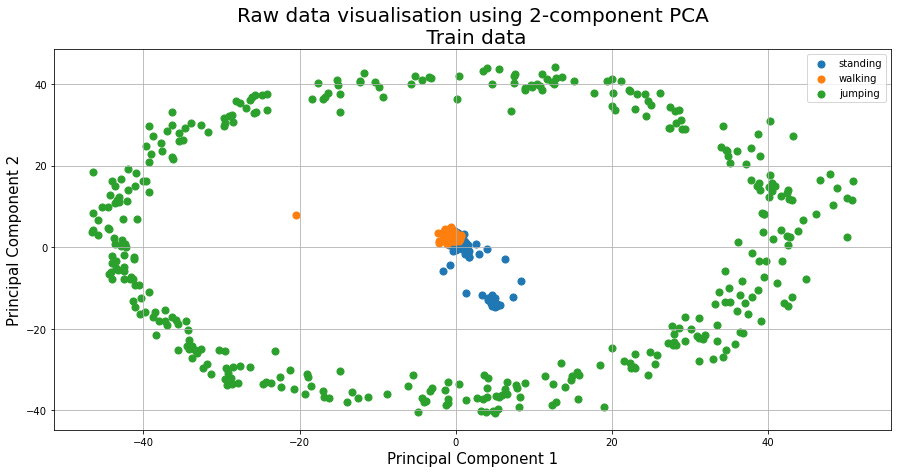

In [22]:
model = PCA(n_components=2)
visualisation(model,X_train,y_train,activity,'Raw data visualisation using 2-component PCA')

## Data Tranformation
Focus on dimensionality reduction to keep only core patterns and characteristics in the data.

### PCA representation
Hyperparameter : No. of Principal Components

In [ ]:
pca = PCA()
pca.fit(X_train)

In [ ]:
# Picking important patterns by using — explained cumulative variance and elbow method.
# a) explained cumulative variance — pick principal components that encode 90% of the total variance.
cumulative_variance_explained = pd.Series(pca.explained_variance_ratio_).cumsum()*100
fig = plt.figure(figsize = (10,5))
plt.plot(cumulative_variance_explained[::40],label='cumulative explained variance')
plt.xticks(np.arange(0, X_train.shape[1], 50))
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative variance Ratio')
plt.axhline(y = 90, color='k', linestyle='--', label = '90% Explained Variance')
plt.legend(loc='best')


# b) Plot eigenvalue for each component and use the elbow method to determine the cut-off point.
eigenvalues = pd.Series(pca.explained_variance_)
fig = plt.figure(figsize = (10,5))
plt.plot(eigenvalues[::35], 'red')
plt.xticks(np.arange(0, X_train.shape[1], 50))
plt.xlabel('Principal Component Number')
plt.ylabel('Variance')
plt.show()

In [ ]:
# Taking into account the above plot, the first pca_nc principal components are able to account 
# for 90% of variance in the data.
pca_nc = 75
feature_vector = pca.components_[0:pca_nc,:]

# Representing train, validation and test data in terms of the first 100 principal components.
X_train_pca = np.dot(X_train, np.transpose(feature_vector))
X_test_pca = np.dot(X_test, np.transpose(feature_vector))

In [ ]:
# storing data in final_data
final_data['pca'] = {}

final_data['pca']['X_train'] = X_train_pca.copy()
final_data['pca']['X_test'] = X_test_pca.copy()

print('PCA transformed data')
print('X_train : {}  y_train : {}'.format(final_data['pca']['X_train'].shape,y_train.shape))
print('X_test : {}  y_test : {}'.format(final_data['pca']['X_test'].shape,y_test.shape))

In [ ]:
#model = PCA(n_components=2)
#visualisation(model,X_train_pca,y_train,activity,'PCA transformed data visualisation using 2-component PCA')

### Kernel PCA representation
Hyperparameter : No. of Principal Components, kernel, gamma

Reconstruction error is chosen as the measure of Kernel PCA performance.

Note : find a point ("pre-image") in the original space that would be mapped as close as possible to this reconstruction point, and then measure the distance between the test point and this pre-image as reconstruction error.

In [ ]:
def reconstruct(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

In [ ]:
# Use grid search on the train data to find the optimal hyperparameters.
# Here, we use 5-fold cross validation to tune the hyperparameters.
param_grid = [{
        "gamma": [1e-1, 1, 1e1],
        "kernel": ["poly", "rbf"]
    }]

kpca_model = KernelPCA(fit_inverse_transform = True) 
kpca_grid = GridSearchCV(kpca_model, param_grid, cv = 5, scoring = reconstruct, verbose = 1)
kpca_grid.fit(X_train)

In [ ]:
# View the accuracy score
print('Best score for training data:', kpca_grid.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best gamma:',kpca_grid.best_estimator_.gamma,"\n") 
print('Best Kernel:',kpca_grid.best_estimator_.kernel,"\n")


In [ ]:
# fitting kpca with best estimated hyperparameters
kpca = KernelPCA(gamma=kpca_grid.best_estimator_.gamma, kernel=kpca_grid.best_estimator_.kernel)
kpca.fit(X_train)

In [ ]:
# Picking important patterns by using — explained cumulative variance and elbow method.
# a) explained cumulative variance — pick principal components that encode 90% of the total variance.
eigenvalues = pd.Series(kpca.eigenvalues_)
cumulative_variance_explained = pd.Series(eigenvalues/sum(eigenvalues)).cumsum()*100
fig = plt.figure(figsize = (10,5))
plt.plot(cumulative_variance_explained,label='cumulative explained variance')
plt.xticks(np.arange(0, len(cumulative_variance_explained), 100))
plt.xlabel('Principal Component Number')
plt.ylabel('Cumulative variance Ratio')
plt.axhline(y = 90, color='k', linestyle='--', label = '90% Explained Variance')
plt.legend(loc='best')


# b) Plot eigenvalue for each component and use the elbow method to determine the cut-off point.
fig = plt.figure(figsize = (10,5))
plt.plot(eigenvalues, 'red')
plt.xticks(np.arange(0, len(eigenvalues), 1000))
plt.xlabel('Principal Component Number')
plt.ylabel('Variance')
plt.show()

In [ ]:
# Taking into account the above plot, the first kpca_nc principal components are able to account 
# for 90% of variance in the data.
kpca_nc = 830

# Representing train, validation and test data in terms of the first kpca_nc principal components.
kpca1 = KernelPCA(n_components=kpca_nc,gamma=kpca_grid.best_estimator_.gamma, kernel=kpca_grid.best_estimator_.kernel)

X_train_kpca = kpca1.fit_transform(X_train)
X_test_kpca = kpca1.transform(X_test)

In [ ]:
# storing data in final_data
final_data['kpca'] = {}

final_data['kpca']['X_train'] = X_train_kpca.copy()
final_data['kpca']['X_test'] = X_test_kpca.copy()

print('X_train : {}  y_train : {}'.format(final_data['kpca']['X_train'].shape,y_train.shape))
print('X_test : {}  y_test : {}'.format(final_data['kpca']['X_test'].shape,y_test.shape))

In [ ]:
#model = KernelPCA(n_components=2)
#visualisation(model,X_train,y_train,activity,'KPCA transformed data visualisation using 2-component PCA')

### Laplacian Eigenmap (LE )representation

In [ ]:
import fastlapmap

m=fastlapmap.LapEigenmap(X_train,n_eigs=2,k=2)

In [ ]:
# Finding the intrinsic dimensionality for the data using Manifold-Adaptive Dimension Estimation

le_comps = int(skdim.id.MADA().fit(X_train).dimension_)
print(le_comps)
le = SpectralEmbedding(random_state=seed,n_components=2) 

X_train_le = le.fit_transform(X_train)
#X_test_le = le.transform(X_test)

In [ ]:
X_train_le

## Classifying activities

In [ ]:
# function to evaluate the classification performance using confusion matrix.
def evaluate(y,y_pred ):

    # Making the Confusion Matrix

    print(confusion_matrix(y,y_pred))
    print("\n")
    print(classification_report(y,y_pred))


    result = confusion_matrix(y,y_pred)
    cl = ['STANDING',
                   'WALKING',
                       'JUMPING']
    fig = plt.figure()
    ax = fig.add_subplot(111)

    cax = ax.matshow(result)

    fig.colorbar(cax)
    ax.set_xticklabels([''] + cl,rotation = 90)
    ax.set_yticklabels([''] + cl)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return


### KNN clustering

In [ ]:
# returns error for classification
def make_scorer(clf, X, y):
    y_pred = clf.predict(X)
    acc = sum(y_pred==y) / len(y)
    return -1*(1-acc)  

In [ ]:
# Running KNN using 5-fold stratified grid search on k and distance metric parameters.
k_range = list(range(1, 21))
metric = ['euclidean', 'manhattan','chebyshev','minkowski']
param_grid = dict(n_neighbors=k_range, metric = metric)

for i in final_data.keys():

    print('DATA REPRESENTATION : {}'.format(i))
    X_tr = final_data[i]['X_train'].copy()
    X_te = final_data[i]['X_test'].copy()
    
    knn = KNeighborsClassifier()

    # defining parameter range
    cv = StratifiedKFold(n_splits=5, random_state=seed,shuffle=True)
    grid_knn = GridSearchCV(knn, param_grid, cv=cv, scoring=make_scorer,verbose=1)

    # fitting the model for grid search
    grid_search=grid_knn.fit(X_tr, y_train)

    # finding the best estimator
    final_knn = grid_knn.best_estimator_
    print("\nBest parameters : {}".format(final_knn))
    print("\nTraining set score for SVM: %f" % final_knn.score(X_tr , y_train))

    # predicting labels for the test data
    y_pred = final_knn.predict(X_te)

    # evaluating the model
    evaluate(y_test,y_pred)
    
    print("***********************************************************************************")

### kSVM

In [ ]:
# Running KNN using 5-fold stratified grid search on k and distance metric parameters.
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['poly', 'rbg', 'sigmoid','linear']}

for i in final_data.keys():

    print('DATA REPRESENTATION : {}'.format(i))
    X_tr = final_data[i]['X_train'].copy()
    X_te = final_data[i]['X_test'].copy()
    
    svc = SVC()

    # defining parameter range
    cv = StratifiedKFold(n_splits=5, random_state=seed,shuffle=True)
    grid_svm = GridSearchCV(svc, param_grid, cv=cv,verbose=1)

    # fitting the model for grid search
    grid_search=grid_svm.fit(X_tr, y_train)

    # finding the best estimator
    final_svm = grid_svm.best_estimator_
    print("\nBest parameters : {}".format(final_svm))
    print("\nTraining set score for SVM: %f" % final_svm.score(X_tr , y_train))

    # predicting labels for the test data
    y_pred = final_svm.predict(X_te)

    # evaluating the model
    evaluate(y_test,y_pred)
    
    print("***********************************************************************************")